### Imports

In [1]:
import re #data cleaning
import string #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing\
import TextVectorization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.initializers import Constant


from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### Environment

In [2]:
data_file_train = '..\\input\\movie-review-sentiment-analysis-kernels-only\\train.tsv'
data_file_test = '..\\input\\movie-review-sentiment-analysis-kernels-only\\test.tsv'
embed_file = '..\\input\\glove-global-vectors-for-word-representation\\glove.6B.200d.txt'

In [3]:
embed_dim = 200

### Data

#### read the data files into data frames

In [4]:
pd.set_option('display.max_colwidth', -1)
df_train = pd.read_csv(data_file_train, delimiter='\t')
df_test = pd.read_csv(data_file_test, delimiter='\t')
print('***Training Set:***\n', df_train.head(1))
print('***Testing Set:***\n', df_test.head(1))

C:\Users\jeete\.conda\envs\Python37Env\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


***Training Set:***
    PhraseId  SentenceId  \
0  1         1            

                                                                                                                                                                                         Phrase  \
0  A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .   

   Sentiment  
0  1          
***Testing Set:***
    PhraseId  SentenceId  \
0  156061    8545         

                                                   Phrase  
0  An intermittently pleasing but mostly routine effort .  


#### cleaning the data

In [5]:
#drop unwanted columns
def retain_cols(df, cols):
    df = df[cols]
    return df

#Turn url's into url, remove anything that's not alphanumeric or a space.
#Then lowercase what's left.
def clean_str(in_str):
    in_str = str(in_str)
    # replace urls with 'url'
    in_str = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\
    [a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\
    [a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}\
    |https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\
    \.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})",\
                    "url", in_str)
    in_str = re.sub(r'([^\s\w]|_)+', '', in_str)
    return in_str.strip().lower()

#clean the data
def clean_data(df, cols):
    df = retain_cols(df, cols)
    df['Text'] = df['Phrase'].apply(clean_str)
    return df

df_train = clean_data(df_train, ['Phrase', 'Sentiment'])
df_test = clean_data(df_test, ['Phrase'])

C:\Users\jeete\.conda\envs\Python37Env\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### balancing classes

Our data is classified into 5 different classes, very negative, slightly negative, neutral, slightly positive and very positive.

Sadly our dataset isn't balanced, so we need to do that ourselves

NOTE: <font color='orange'>using alias 'df' for 'df_train'</font> for convenience

In [6]:
df = df_train

In [7]:
df.Sentiment.value_counts()

2    79582
3    32927
1    27273
4    9206 
0    7072 
Name: Sentiment, dtype: int64

In [8]:
df_0 = df[df['Sentiment'] == 0].sample(frac=1)
df_1 = df[df['Sentiment'] == 1].sample(frac=1)
df_2 = df[df['Sentiment'] == 2].sample(frac=1)
df_3 = df[df['Sentiment'] == 3].sample(frac=1)
df_4 = df[df['Sentiment'] == 4].sample(frac=1)

In [9]:
# we want a balanced set for training against - there are 7072 `0` examples
sample_size = 7072

data = pd.concat([df_0.head(sample_size),\
                  df_1.head(sample_size),\
                  df_2.head(sample_size),\
                  df_3.head(sample_size),\
                  df_4.head(sample_size)]).sample(frac=1)
data.head(3)

,Phrase,Sentiment,Text
126436,as a coherent whole,2,as a coherent whole
105675,the greatness,4,the greatness
118554,in this shower of black-and-white psychedelia,2,in this shower of blackandwhite psychedelia


NOTE: <font color='orange'>'data' represents 'df_train' after data preprocessing</font>

#### input vectorization

##### sequence length and max features

In [10]:
data['l'] = data['Text'].apply(lambda x: len(str(x).split(' ')))
print("mean length of sentence: " + str(data.l.mean()))
print("max length of sentence: " + str(data.l.max()))
print("std dev length of sentence: " + str(data.l.std()))

mean length of sentence: 8.852912895927602
max length of sentence: 51
std dev length of sentence: 7.795155206603288


In [11]:
# these sentences aren't that long so we may as well use the whole string
sequence_length = int(data.l.max())

In [12]:
max_features = 20000 # this is the number of words we care about

##### vocabulary

In [13]:
vectorizer = TextVectorization(max_tokens=max_features,\
                               output_sequence_length=sequence_length)
text_ds = tf.data.Dataset.from_tensor_slices(data['Text'].values).batch(128)
vectorizer.adapt(text_ds)
voc = vectorizer.get_vocabulary()
print('Vocabulary:', voc[:5])
print('Vectorizing "the cat sat on the mat":\n',\
     vectorizer([["the cat sat on the mat"]]).numpy()[0, :6])
word_index = dict(zip([x.decode('utf-8') for x in voc], range(len(voc))))
print('Word index of words ["the", "cat", "sat", "on", "the", "mat"]:', \
      [word_index[w] for w in ["the", "cat", "sat", "on", "the", "mat"]])

Vocabulary: [b'the', b'a', b'and', b'of', b'to']
Vectorizing "the cat sat on the mat":
 [    2  2983  8788    22     2 11324]
Word index of words ["the", "cat", "sat", "on", "the", "mat"]: [0, 2981, 8786, 20, 0, 11322]


NOTE: The index of vectorizing is off by 2 when compared with word index generated from its vocabulary. We will have to <font color='blue'>make adjustment of 2 when creating the embedding matrix.</font>

##### vectorize input and split for validation

In [14]:
X = vectorizer(np.array([[s] for s in data['Text'].values])).numpy()
y = np.array(pd.get_dummies(data['Sentiment']).values)

In [15]:
# where there isn't a test set, Kim keeps back 10% of the data for testing,
#I'm going to do the same since we have an ok amount to play with
X_train, X_val, y_train, y_val =\
train_test_split(X, y, test_size=0.1)
print("Validation set size " + str(len(X_val)))

Validation set size 3536


### Word Embeddings

#### load GloVe embeddings

In [16]:
embeddings_index = {}
f_embed = open(embed_file, encoding="utf8")
for line in f_embed:
    tokens = line.split()
    word = tokens[0]
    coefs = np.asarray(tokens[1:], dtype='float32')
    embeddings_index[word] = coefs
f_embed.close()
print('Found %s word vectors' % len(embeddings_index))

Found 400000 word vectors


#### embedding matrix

In [17]:
num_words = min(max_features, len(word_index)) + 2
embedding_dim = embed_dim
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i+2] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 13499 words (1463 misses)


### Model

#### model architecture

In [18]:
num_filters = 100

In [19]:
inputs_3 = Input(shape=(sequence_length,), dtype='int32')
embedding_layer_3 = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True)(inputs_3)

reshape_3 = Reshape((sequence_length, embedding_dim, 1))(embedding_layer_3)

# note the relu activation
conv_0_3 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_3)
conv_1_3 = Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_3)
conv_2_3 = Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_3)

maxpool_0_3 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_3)
maxpool_1_3 = MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_3)
maxpool_2_3 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_3)

concatenated_tensor_3 = Concatenate(axis=1)([maxpool_0_3, maxpool_1_3, maxpool_2_3])
flatten_3 = Flatten()(concatenated_tensor_3)

dropout_3 = Dropout(0.5)(flatten_3)
output_3 = Dense(units=5, activation='softmax')(dropout_3)

In [20]:
model_3 = Model(inputs=inputs_3, outputs=output_3)
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_3.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 51)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 51, 200)      2992800     input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 51, 200, 1)   0           embedding[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 49, 1, 100)   60100       reshape[0][0]                    
______________________________________________________________________________________________

#### fit the model

In [21]:
batch_size = 32
history_3 = model_3.fit(X_train, y_train,\
                        epochs=20, batch_size=batch_size,\
                        verbose=1, validation_split=0.2)

Train on 25459 samples, validate on 6365 samples
Epoch 1/20
25459/25459 [==============================] - 45s 2ms/sample - loss: 1.8741 - accuracy: 0.3235 - val_loss: 1.7950 - val_accuracy: 0.4606
Epoch 2/20
25459/25459 [==============================] - 46s 2ms/sample - loss: 1.7895 - accuracy: 0.4561 - val_loss: 1.7728 - val_accuracy: 0.4900
Epoch 3/20
25459/25459 [==============================] - 45s 2ms/sample - loss: 1.6925 - accuracy: 0.5079 - val_loss: 1.7373 - val_accuracy: 0.5181
Epoch 4/20
25459/25459 [==============================] - 46s 2ms/sample - loss: 1.6284 - accuracy: 0.5356 - val_loss: 1.6358 - val_accuracy: 0.5412
Epoch 5/20
25459/25459 [==============================] - 48s 2ms/sample - loss: 1.5968 - accuracy: 0.5486 - val_loss: 1.6221 - val_accuracy: 0.5414
Epoch 6/20
25459/25459 [==============================] - 47s 2ms/sample - loss: 1.5597 - accuracy: 0.5635 - val_loss: 1.6738 - val_accuracy: 0.5427
Epoch 7/20
25459/25459 [==============================] -

#### plot training and validation accuracy

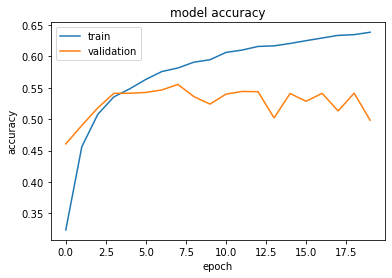

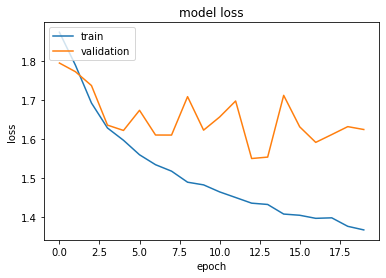

In [22]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### accuracy

In [23]:
y_hat_3 = model_3.predict(X_val)
accuracy_score(list(map(lambda x: np.argmax(x), y_val)),\
               list(map(lambda x: np.argmax(x), y_hat_3)))

0.5050904977375565

#### confusion matrix

In [25]:
confusion_matrix(list(map(lambda x: np.argmax(x), y_val)),\
                 list(map(lambda x: np.argmax(x), y_hat_3)))

array([[425, 226,  39,  13,   1],
       [187, 326, 174,  43,   3],
       [ 25, 101, 477,  97,   4],
       [ 23,  70, 182, 324,  55],
       [ 19,  22,  56, 410, 234]], dtype=int64)

### Testing

In [35]:
X_test = vectorizer(np.array([[s] for s in df_test['Text'].values])).numpy()
y_test = model_3.predict(X_test)

#### compare test.tsv file with these results

In [54]:
[(i+1, list(y).index(max(y))) for i, y in enumerate(y_test)]

[(1, 3),
 (2, 3),
 (3, 2),
 (4, 3),
 (5, 3),
 (6, 3),
 (7, 3),
 (8, 2),
 (9, 3),
 (10, 2),
 (11, 2),
 (12, 2),
 (13, 2),
 (14, 2),
 (15, 2),
 (16, 1),
 (17, 2),
 (18, 1),
 (19, 1),
 (20, 2),
 (21, 2),
 (22, 2),
 (23, 1),
 (24, 2),
 (25, 2),
 (26, 2),
 (27, 2),
 (28, 2),
 (29, 1),
 (30, 2),
 (31, 1),
 (32, 1),
 (33, 1),
 (34, 2),
 (35, 2),
 (36, 2),
 (37, 1),
 (38, 2),
 (39, 2),
 (40, 2),
 (41, 2),
 (42, 2),
 (43, 2),
 (44, 2),
 (45, 2),
 (46, 2),
 (47, 2),
 (48, 2),
 (49, 2),
 (50, 2),
 (51, 1),
 (52, 2),
 (53, 1),
 (54, 1),
 (55, 2),
 (56, 2),
 (57, 2),
 (58, 2),
 (59, 2),
 (60, 2),
 (61, 1),
 (62, 2),
 (63, 1),
 (64, 1),
 (65, 2),
 (66, 2),
 (67, 2),
 (68, 2),
 (69, 2),
 (70, 2),
 (71, 2),
 (72, 2),
 (73, 2),
 (74, 2),
 (75, 2),
 (76, 2),
 (77, 2),
 (78, 2),
 (79, 2),
 (80, 2),
 (81, 2),
 (82, 2),
 (83, 2),
 (84, 2),
 (85, 2),
 (86, 2),
 (87, 2),
 (88, 2),
 (89, 2),
 (90, 2),
 (91, 2),
 (92, 2),
 (93, 2),
 (94, 3),
 (95, 2),
 (96, 2),
 (97, 2),
 (98, 2),
 (99, 2),
 (100, 2),
 (101, 2

In [58]:
results = [(i+1, list(y).index(max(y))) for i, y in enumerate(y_test)]
results[23906]

(23907, 1)

In [66]:
X_test = vectorizer(np.array([[s] for s in ['amazing', 'thrilling experience', 'expected more', 'it was fun', 'waste of time']])).numpy()
y_test = model_3.predict(X_test)
[(i+1, list(y).index(max(y))) for i, y in enumerate(y_test)]

[(1, 3), (2, 3), (3, 2), (4, 3), (5, 0)]

### Model - Bidirectional GRU and LSTM

#### Imports

In [99]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, \
Callback, EarlyStopping
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout,\
Activation, Conv1D, GRU, GRU, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model

#### Constants

In [100]:
max_len = sequence_length
embed_size = embedding_dim

In [101]:
embed_size

200

In [102]:
def build_model1(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, conv_size=32):
    file_path = "best_model.hdf5"
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)
    
    inp = Input(shape = (max_len,))
    x = Embedding(num_words, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(GRU(units, return_sequences = True))(x1)
    x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x1)
    max_pool1_gru = GlobalMaxPooling1D()(x1)
    
    x3 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool3_gru = GlobalAveragePooling1D()(x3)
    max_pool3_gru = GlobalMaxPooling1D()(x3)
    
    x_lstm = Bidirectional(LSTM(units, return_sequences = True))(x1)
    x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool1_lstm = GlobalAveragePooling1D()(x1)
    max_pool1_lstm = GlobalMaxPooling1D()(x1)
    
    x3 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool3_lstm = GlobalAveragePooling1D()(x3)
    max_pool3_lstm = GlobalMaxPooling1D()(x3)
    
    
    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool3_gru, max_pool3_gru,
                    avg_pool1_lstm, max_pool1_lstm, avg_pool3_lstm, max_pool3_lstm])
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(5, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    history = model.fit(X_train, y_train, batch_size = 128, epochs = 20, validation_split=0.1, 
                        verbose = 1, callbacks = [check_point, early_stop])
    model = load_model(file_path)
    return model, history

In [103]:
model1, history1 = build_model1(lr = 1e-3, lr_d = 1e-10, units = 64,\
                      spatial_dr = 0.3, kernel_size1=3, kernel_size2=2,\
                      dense_units=32, dr=0.1, conv_size=32)

Train on 28641 samples, validate on 3183 samples
Epoch 1/20
28544/28641 [============================>.] - ETA: 0s - loss: 0.5017 - accuracy: 0.7658
Epoch 00001: val_loss improved from inf to 0.42677, saving model to best_model.hdf5
28641/28641 [==============================] - 56s 2ms/sample - loss: 0.5015 - accuracy: 0.7660 - val_loss: 0.4268 - val_accuracy: 0.8137
Epoch 2/20
28544/28641 [============================>.] - ETA: 0s - loss: 0.4147 - accuracy: 0.8116
Epoch 00002: val_loss improved from 0.42677 to 0.38214, saving model to best_model.hdf5
28641/28641 [==============================] - 56s 2ms/sample - loss: 0.4146 - accuracy: 0.8116 - val_loss: 0.3821 - val_accuracy: 0.8287
Epoch 3/20
28544/28641 [============================>.] - ETA: 0s - loss: 0.3960 - accuracy: 0.8212
Epoch 00003: val_loss did not improve from 0.38214
28641/28641 [==============================] - 58s 2ms/sample - loss: 0.3959 - accuracy: 0.8213 - val_loss: 0.3995 - val_accuracy: 0.8246
Epoch 4/20
285

In [104]:
history_3 = history1

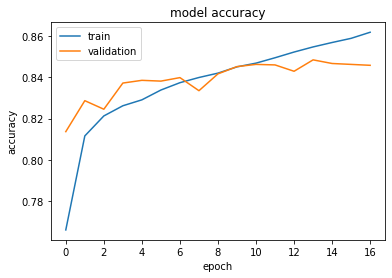

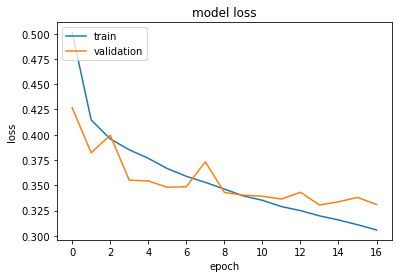

In [105]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [106]:
model_3 = model1

#### accuracy

In [107]:
y_hat_3 = model_3.predict(X_val)
accuracy_score(list(map(lambda x: np.argmax(x), y_val)),\
               list(map(lambda x: np.argmax(x), y_hat_3)))

0.5933257918552036

#### confusion matrix

In [108]:
confusion_matrix(list(map(lambda x: np.argmax(x), y_val)),\
                 list(map(lambda x: np.argmax(x), y_hat_3)))

array([[494, 170,  11,  19,  10],
       [219, 372,  86,  49,   7],
       [ 29, 133, 398, 122,  22],
       [ 20,  67,  94, 263, 210],
       [ 13,  18,  18, 121, 571]], dtype=int64)

### Testing

In [109]:
X_test = vectorizer(np.array([[s] for s in df_test['Text'].values])).numpy()
y_test = model_3.predict(X_test)

#### compare test.tsv file with these results

In [110]:
[(i+1, list(y).index(max(y))) for i, y in enumerate(y_test)]

[(1, 3),
 (2, 3),
 (3, 2),
 (4, 3),
 (5, 3),
 (6, 3),
 (7, 3),
 (8, 2),
 (9, 3),
 (10, 2),
 (11, 2),
 (12, 2),
 (13, 2),
 (14, 2),
 (15, 2),
 (16, 4),
 (17, 2),
 (18, 4),
 (19, 4),
 (20, 3),
 (21, 2),
 (22, 2),
 (23, 0),
 (24, 2),
 (25, 2),
 (26, 2),
 (27, 2),
 (28, 2),
 (29, 4),
 (30, 2),
 (31, 3),
 (32, 3),
 (33, 1),
 (34, 2),
 (35, 2),
 (36, 2),
 (37, 1),
 (38, 2),
 (39, 2),
 (40, 2),
 (41, 2),
 (42, 2),
 (43, 2),
 (44, 2),
 (45, 2),
 (46, 2),
 (47, 2),
 (48, 2),
 (49, 2),
 (50, 2),
 (51, 1),
 (52, 2),
 (53, 1),
 (54, 2),
 (55, 2),
 (56, 2),
 (57, 2),
 (58, 2),
 (59, 2),
 (60, 2),
 (61, 2),
 (62, 2),
 (63, 2),
 (64, 2),
 (65, 2),
 (66, 2),
 (67, 2),
 (68, 1),
 (69, 2),
 (70, 1),
 (71, 2),
 (72, 1),
 (73, 2),
 (74, 2),
 (75, 2),
 (76, 1),
 (77, 2),
 (78, 1),
 (79, 1),
 (80, 1),
 (81, 1),
 (82, 2),
 (83, 2),
 (84, 2),
 (85, 2),
 (86, 2),
 (87, 2),
 (88, 2),
 (89, 2),
 (90, 2),
 (91, 2),
 (92, 2),
 (93, 2),
 (94, 4),
 (95, 3),
 (96, 2),
 (97, 3),
 (98, 2),
 (99, 2),
 (100, 2),
 (101, 2

In [111]:
results = [(i+1, list(y).index(max(y))) for i, y in enumerate(y_test)]
results[23906]

(23907, 0)

In [112]:
X_test = vectorizer(np.array([[s] for s in ['amazing', 'thrilling experience', 'expected more', 'it was fun', 'waste of time']])).numpy()
y_test = model_3.predict(X_test)
[(i+1, list(y).index(max(y))) for i, y in enumerate(y_test)]

[(1, 4), (2, 4), (3, 2), (4, 4), (5, 0)]